# PART A : Set up environment and load datasets

## 1 Mount Google drive and install cartopy

In [ ]:
# link to drive where datasets are stored
import os, sys
from google.colab import drive
drivedir='/content/drive'
drive.mount(drivedir)
os.chdir(drivedir)

Mounted at /content/drive


In [ ]:
# install required modules I
!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install cython
!pip install cartopy

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libproj-dev is already the newest version (8.2.1-1).
libproj-dev set to manually installed.
proj-data is already the newest version (8.2.1-1).
proj-data set to manually installed.
The following NEW packages will be installed:
  proj-bin
0 upgraded, 1 newly installed, 0 to remove and 19 not upgraded.
Need to get 154 kB of archives.
After this operation, 492 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 proj-bin amd64 8.2.1-1 [154 kB]
Fetched 154 kB in 0s (354 kB/s)
Selecting previously unselected package proj-bin.
(Reading database ... 120874 files and directories currently installed.)
Preparing to unpack .../proj-bin_8.2.1-1_amd64.deb ...
Unpacking proj-bin (8.2.1-1) ...
Setting up proj-bin (8.2.1-1) ...
Processing triggers for man-db (2.10.2-1) ...
Reading package lists... Done
Building dependency tree... Done
Reading state informatio

In [ ]:
# install required modules II
!apt-get -qq install python-cartopy python3-cartopy
!pip uninstall -y shapely # cartopy and shapely aren't friends (early 2020)
!pip install shapely --no-binary shapely

E: Unable to locate package python-cartopy
Found existing installation: shapely 2.0.2
Uninstalling shapely-2.0.2:
  Successfully uninstalled shapely-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.7/279.7 kB 6.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for shapely: filename=shapely-2.0.2-cp310-cp310-linux_x86_64.whl size=1027121 sha256=72c59d084690ffe8fed30f038e52d346e74ba8fd98c08906aad9effaaad41a2d
  Stored in directory: /root/.cache/pip/wheels/1f/6b/52/14cb4558cddc0fd89de08f0e1fd08f816f4f3e1969311377c6
Successfully built shapely
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
li

In [ ]:
# import modules
import cartopy  #cartography library
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point #
import cartopy.mpl.ticker as cticker
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.dates import DateFormatter
from scipy import signal
import copy


## 2 Load datasets using xarray

In [ ]:
datadir=drivedir+'/MyDrive/TASI_data_2023/'

# 2D ERA5
dse=xr.open_dataset(datadir+'/ERA5_1958-2022_newg.nc')
# change units
dse['t2m']=dse['t2m']-273.15
dse['t2m'] = dse.t2m.assign_attrs(units='°C')
dse['sst']=dse['sst']-273.15
dse['sst'] = dse.sst.assign_attrs(units='°C')
dse['tp']=dse['tp']*1000 #*30.5
dse['tp'] = dse.tp.assign_attrs(units='mm/day') # mm accumulated in a month,


# 3D ERA5
dse3=xr.open_dataset(datadir+'/ERA5_3D_2012-2022_newg.nc')
# change units
dse3['t']=dse3['t']-273.15
dse3['t'] = dse3.t.assign_attrs(units='°C')


# ORAS5
dso=xr.open_dataset(datadir+'/ORAS5_1958-2022_newg.nc')
dso=dso.rename({'time_counter': 'time'}) #rename dimension time_counter so that it matches ERA5 name for time dimension

## 3 Season climatology and zonal average for ERA5

In [ ]:
# Calculate seasonal climatology using groupby
dse_seas_clm = dse.groupby("time.season").mean('time')
dse3_seas_clm = dse3.groupby("time.season").mean('time')
dso_seas_clm = dso.groupby("time.season").mean('time')


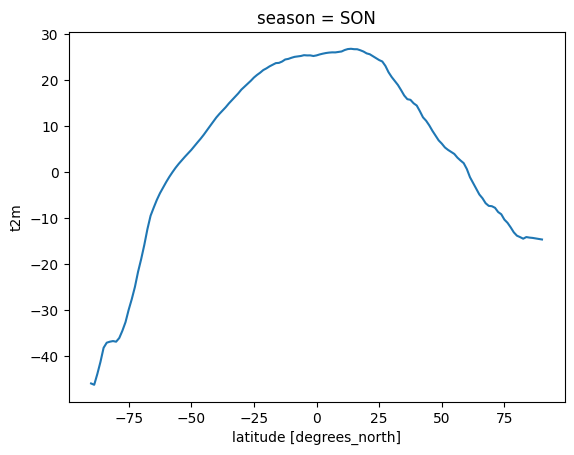

In [ ]:
# Check
dse_seas_zavg=dse_seas_clm.mean(dim='lon')
dse_seas_zavg.t2m.sel(season='SON').plot()

----------------------------------------------------------
# PART B : Main features of tropical atmosphere

**Reference** :
<a id="#ref">\[1\]</a> Webster, Peter. *Dynamics of The Tropical Atmosphere and Oceans.* 1st ed., Wiley, 2020. *DOI.org (Crossref)*, https://doi.org/10.1002/9781118648469.


## 1 Latitudinal distribution of the zonally averaged sea-surface temperature

In [ ]:
def format_lat(value, tick_number):
    # change ticks label depending on degree north or south
    if value < 0:
        return  '{x}°S'.format(x=-value)
    elif value > 0:
        return '{x}°N'.format(x=value)
    else:
        return value

In [ ]:
plt.rcParams['contour.negative_linestyle'] = 'solid'  #so that the negative contours are not dashed

Text(-39, 27, '$[\\overline{T}_{SST(\\phi)}]$')

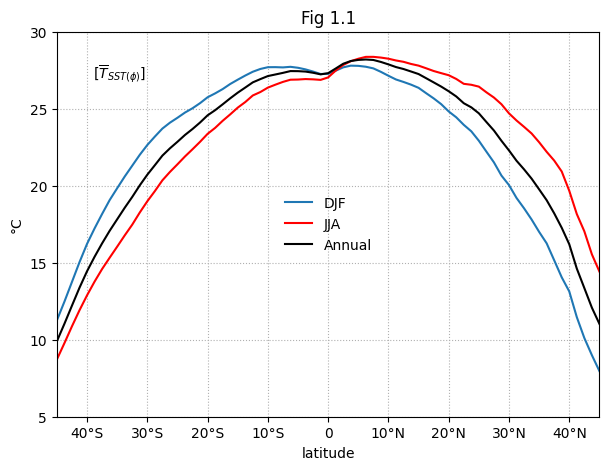

In [ ]:
SST_zavg=dse_seas_clm['sst'].mean(dim='lon')

fig, ax = plt.subplots(figsize=(7,5))
ax.plot(dse.lat.sel(lat=slice(-45,45)),SST_zavg.sel(season='DJF').sel(lat=slice(-45,45)),c='#1f77b4', label='DJF')
ax.plot(dse.lat.sel(lat=slice(-45,45)),SST_zavg.sel(season='JJA').sel(lat=slice(-45,45)),c='r', label='JJA')
ax.plot(dse.lat.sel(lat=slice(-45,45)),SST_zavg.mean(dim='season').sel(lat=slice(-45,45)),c='k', label = 'Annual')

# Major ticks every 10 for latitude, major ticks every 5 for temperature
major_xticks = np.arange(-40, 41, 10) # last value is not included so if we want all the way to 40 we have to choose something greater
major_yticks = np.arange(5, 31, 5)
ax.set_xticks(major_xticks)
ax.set_yticks(major_yticks)

# And a corresponding grid
ax.grid(which='both', linestyle=':')
ax.set_xlim(-45,45)

# title, labels, legend, ticks format, annotation
ax.set_title('Fig 1.1')
ax.set_xlabel('latitude')
ax.set_ylabel('°C')
ax.legend(loc='center',framealpha=0, frameon ='False')
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_lat))
ax.annotate(r'$[\overline{T}_{SST(\phi)}]$',xy=(-39,27))

*Discuss with a couple of sentences the hemispheric asymmetry.*

The blue curve, corresponding to the zonally averaged sea-surface temperature (sst) during austral summer (DJF) is mostly symmetric with respect to the equator. The maximum sst in both the southern hemisphere (SH) and the northern hemisphere (NH) is about equal.
The red curve, corresponding to the zonally averaged sst for boreal summer (JJA) presents an asymmetry which can also be seen in the annual average: the sst maximum in the NH is greater by about 2°C with respect to that of the southern hemisphere.
Note that for a same season (ie looking at the blue curve in NH and the red curve in SH for winter and opposite for summer), the NH always has greater sst values.
The other asymmetry to note is the difference in the gradient of temperature : in latitudes away from the equator for all three curves, the sst diminishes faster in the NH than in the SH.

The asymmetry in sst can be explained by the position of the Intertropical Convergence Zone (ICTZ), solar heating and landmass distribution.
In boreal summer the ICTZ is distinctly in northern latitudes whereas in boreal winter it is located at the equator. The ICTZ is characterized by high convective activity which is directly linked to great values of sst.
Solar heating is asymmetric due to Earth's distance to the sun : this distance in boreal winter is smaller than in austral winter. Equivalently this distance in austral summer is smaller than in boreal summer, so we would expect that sst in austral summer is greater than in boreal summer but this is not the case. This is where we have to take into account the landmass distribution. Indeed, the NH has much more land and SH much more ocean. So since land heats up faster than water, the sst in boreal summer is still greater than that of austral summer.

## 2 Zonally averaged vertical atmospheric temperature and specific humidity

Text(0.5, 0.98, 'Temperature and Specific Humidity')

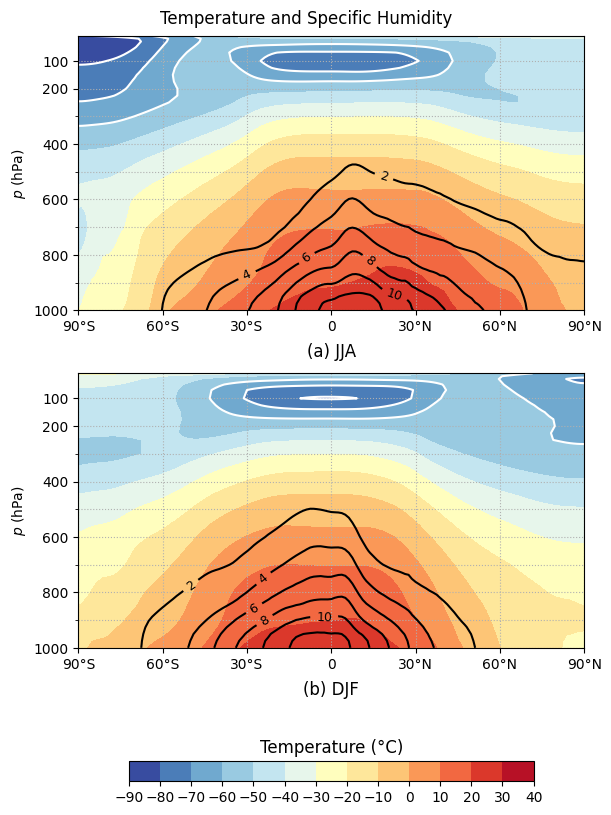

In [ ]:
# Data : Temperature and specific humidity
T_zavg = dse3_seas_clm.t.mean(dim='lon')
Q_zavg = dse3_seas_clm.q.mean(dim='lon')

# Figure
fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(6,8),layout='constrained')

level = np.linspace(-90,40,14)

vivaldi = ['JJA','DJF']

# Major minor ticks
major_xticks = np.arange(-90, 91, 30)
major_yticks = [100, 200, 400, 600, 800, 1000]
minor_yticks = [300, 500, 700, 900]

for i in range(2):  #for ax in axs.flat:
  ax = axs[i]

  # plot
  cs = ax.contourf(dse3['lat'],dse3['level'],T_zavg.sel(season=vivaldi[i]), levels = level, cmap ='RdYlBu_r')
  ax.contour(dse3['lat'],dse3['level'],T_zavg.sel(season=vivaldi[i]), levels = (-80, -70, -60), colors='w')
  cs_h = ax.contour(dse3['lat'],dse3['level'],Q_zavg.sel(season=vivaldi[i])*1e3, colors='k')

  # label h
  ax.clabel(cs_h, inline=True, fontsize=9, levels = (2.5, 5.0, 7.5, 10.0, 12.5), use_clabeltext = 'True', fmt = {2.5: "2", 5: "4", 7.5: "6", 10.0 : "8", 12.5 :"10"})

  # invert and label yaxis
  ax.invert_yaxis()
  ax.set_ylabel('$p$ (hPa)')

  # ticks
  ax.set_xticks(major_xticks)
  ax.set_yticks(major_yticks)
  ax.set_yticks(minor_yticks, minor = 'True')
  ax.xaxis.set_major_formatter(plt.FuncFormatter(format_lat)) # format xaxis

  # grid
  ax.grid(which='both', linestyle=':') # grid


# color bar -->still to check it's the same for both
cbar = fig.colorbar(cs, ax=axs[:], location='bottom', shrink=0.8, ticks=level, extend='both')
cbar.ax.set_title('Temperature (°C)')

# title
axs[0].set_title('(a) JJA', y = -0.2)
axs[1].set_title('(b) DJF', y = -0.2)
fig.suptitle('Temperature and Specific Humidity')

*Which season shows a field that is more symmetric about the equator?*
*Why do you have a season that is more symmetric about the equator?*

DJF is more symmetric about the equator both for the temperature and specific humidity and for most of the pressure layer. This again can be explained by the landmass distribution, ICTZ and earth-sun distance.
The poleward extension of both temperature and specific humidity during JJA is likely to be associated with the northward location of the Asian Monsoon precipitation [\[1\]](#ref).

## 3 Zonally averaged precipitations

In [ ]:
# Create land/sea masks starting from SST
mask = dse.sst[1,:,:].values

# Sea mask
sea_mask = mask.copy()
sea_mask[~np.isnan(sea_mask)] = 1
#plt.pcolor(sea_mask)
#sea_mask.shape

# Land mask
land_mask = mask.copy()
land_mask[~np.isnan(land_mask)] = 0  #temporarily set to 0 to still access
land_mask[np.isnan(land_mask)] = 1   #nan values which we set to 1
land_mask[np.where(land_mask == 0)] = np.nan #and change 0 back to nan
#plt.pcolor(land_mask)

In [ ]:
# Create data to plot
P = dse_seas_clm.tp   #P.shape
P_oce = P*sea_mask
P_lan = P*land_mask

P_zavg = P.mean(dim='lon')
Po_zavg = P_oce.mean(dim='lon')
Pl_zavg = P_lan.mean(dim='lon')

Text(0.5, 1.0, '(iii) Land')

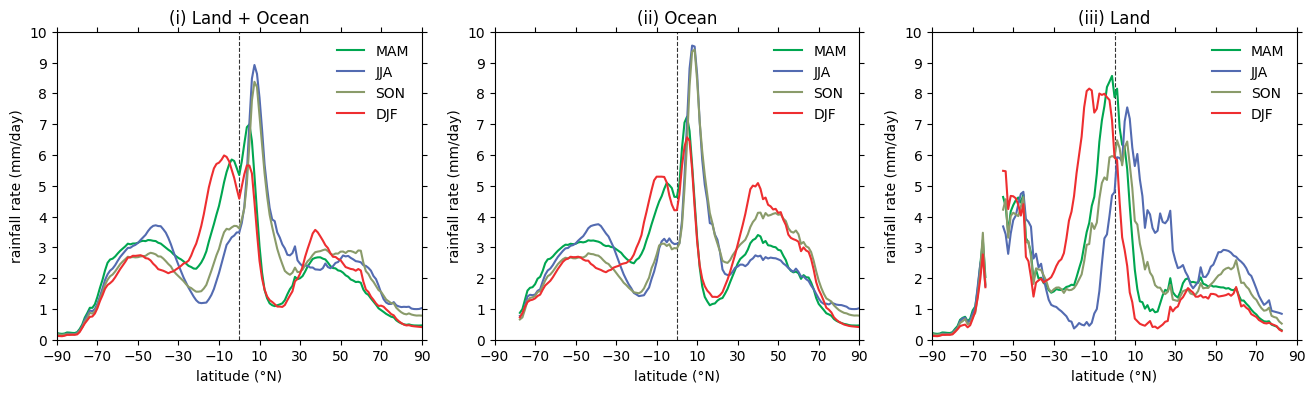

In [ ]:
fig, axs = plt.subplots(nrows = 1, ncols=3, figsize=(16,4))

Ps = [P_zavg, Po_zavg, Pl_zavg] # to loop over with for

# Major ticks
major_xticks = np.arange(-90, 91, 20)
major_yticks = np.arange(0,11,1)

for i in range(3):
  ax = axs[i]

  # Plot
  line = ax.plot([0,0],[0,300], color = 'k', alpha = 0.8, linewidth=0.8, linestyle = '--')
  ax.plot(P_zavg['lat'],Ps[i].sel(season='MAM'), color = '#00a650', label = 'MAM')
  ax.plot(P_zavg['lat'],Ps[i].sel(season='JJA'), color = '#536bb1', label = 'JJA')
  ax.plot(P_zavg['lat'],Ps[i].sel(season='SON'), color = '#8a9b6a', label = 'SON')
  ax.plot(P_zavg['lat'],Ps[i].sel(season='DJF'), color = '#ee2e30', label = 'DJF')

  # Set and format ticks
  ax.set_xticks(major_xticks)
  ax.set_yticks(major_yticks)
  ax.yaxis.set_major_formatter(plt.FixedFormatter(np.arange(0,11,1)))
  ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False,
                     bottom=True, top=True, left=True, right=True)      #add ticks on othersides

  # Set limits
  ax.set_xlim(-90,90)
  ax.set_ylim(0,10)

  # Set labels
  ax.set_xlabel('latitude (°N)')
  ax.set_ylabel('rainfall rate (mm/day)')

  # Legend
  ax.legend(loc='best',framealpha=0, frameon ='False')

# Annotate
axs[0].set_title('(i) Land + Ocean')
axs[1].set_title('(ii) Ocean')
axs[2].set_title('(iii) Land')

*Why do we observe the highest rainfall rate over ocean at about 10N during JJA and SON?*
*Why the highest rainfall rate over land is at the equator during MAM?*

<!-- At 10°N, the landmass corresponds to 1700 km of South America, 7100km of Africa just south of the Sahara desert and 600km of India, Thailand and Philipines totaling to approximately 9400km. The rest is ocean.

At the Equator, the landmass corresponds to a 3800km strip of tropical Africa, and a 3500km strip of the Amazon totaling to 7300km. The rest is ocean. -->


During JJA, following the sun, the ICTZ is at around 10°N explaining the highest rainfall rate over the ocean at that latitude rather than at the equator. Since the heat capacity of the ocean is so great, the ocean stays warm all the way into SON, even if the ICTZ is transitioning to south of the equator for DJF.

During MAM, ie austral autumn, the ICTZ is over the equator transitioning from the summer hemisphere to the winter hemisphere hence the precipitation is the most intence over the equator.

## 4 Mean seasonal surface temperature

Text(0.5, 0.98, 'Surface Land and Ocean Temperatures')

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


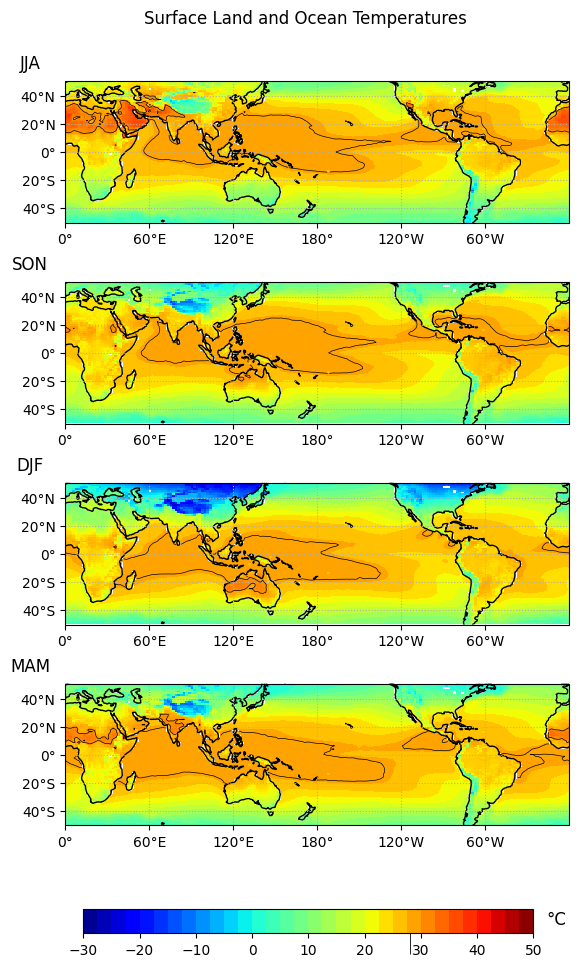

In [ ]:
# Apply mask
SST = sea_mask*dse_seas_clm.sst
T2M = land_mask*dse_seas_clm.t2m

# Figure
fig = plt.figure(figsize = (6,12))
gs = fig.add_gridspec(4,1, left=0.1, bottom=0.28, right=0.94, top=0.94, hspace=0.06)

# Projection
data_crs = ccrs.PlateCarree()

# cmap
cmap_str = 'jet'

# levels
levels = np.arange(-30,51,2.5)

# Ticks
xticks=np.arange(0, 360, 60)
yticks=np.arange(-40, 41, 20)

# lats
lats = dse.lat.sel(lat=slice(-50,50))

# seasons for looping
vivaldi = ['JJA', 'SON', 'DJF', 'MAM']

for i in range(4):

  SST_savg = SST.sel(season=vivaldi[i]).sel(lat=slice(-50,50))
  T2M_savg = T2M.sel(season=vivaldi[i]).sel(lat=slice(-50,50))

  # Add the cyclic point
  SST_savg, lons = add_cyclic_point(SST_savg, coord=dse_seas_clm['lon'])
  T2M_savg, lons = add_cyclic_point(T2M_savg, coord=dse_seas_clm['lon'])

  # Plot
  ax = fig.add_subplot(gs[i,0], projection=ccrs.PlateCarree(central_longitude=180))

  cs = ax.contourf(lons,lats,SST_savg, transform = data_crs, cmap = cmap_str, levels = levels) # sst
  ax.pcolormesh(lons,lats,T2M_savg, transform = data_crs, cmap = cmap_str, vmin = -30, vmax = 50) # t2m

  ax.contour(lons,lats,SST_savg, transform = data_crs, levels = [28], colors = 'k', linewidths = 0.5) # sst
  ax.contour(lons,lats,T2M_savg, transform = data_crs, levels = [30], colors = 'k', linewidths = 0.5) # t2m

  ax.coastlines(resolution='auto', color='k') # coastlines

  # Ticks
  ax.set_xticks(xticks, crs=data_crs)
  ax.set_yticks(yticks, crs=data_crs)
  ax.xaxis.set_major_formatter(cticker.LongitudeFormatter())
  ax.yaxis.set_major_formatter(cticker.LatitudeFormatter())

  # Grid
  ax.grid(which='both', linestyle=':')

  ax.set_title(vivaldi[i], x = -0.07, y = 1.03)


# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.13, 0.21, 0.75, 0.02])   # dimensions [left, bottom, width, height] of the new axes
cbar=fig.colorbar(cs, cax=cbar_ax, orientation='horizontal', shrink = 0.8)
cbar.ax.set_title('°C', x = 1.05, y = 0.03)
cbar.set_ticks(np.arange(-30,51,10))
cbar.set_ticks([28], minor = 'True')
cbar_ax.tick_params(axis='x', which='minor', length= 15, labelbottom = 'True')

# titles
fig.suptitle('Surface Land and Ocean Temperatures')

*Briefly discuss the difference between your plot and the book's plot*

First of all we are using different datasets. Next we are using sst for the ocean just like the book but we are not using land surface temperature, rather two meter temperature (t2m). The t2m data we are using seems to be at a lower resolution than that of the book suggested by the visible pixelization and the badly resolved lakes in our plots.

The ocean contours at 28°C are consistent with those in the book. The land surface temperature contours at 36°C for the book are quasi-absent for t2m in our plots, but rather correspond to the 30°C contour for t2m. This suggests that the temperature difference between the surface and that at 2 meters is about 6°C.

## 5 Asian-Australian monsoon system : precipitation and circulation in the lower atmosphere

Text(0.5, 0.98, 'Asian-Australasian Monsoon System')

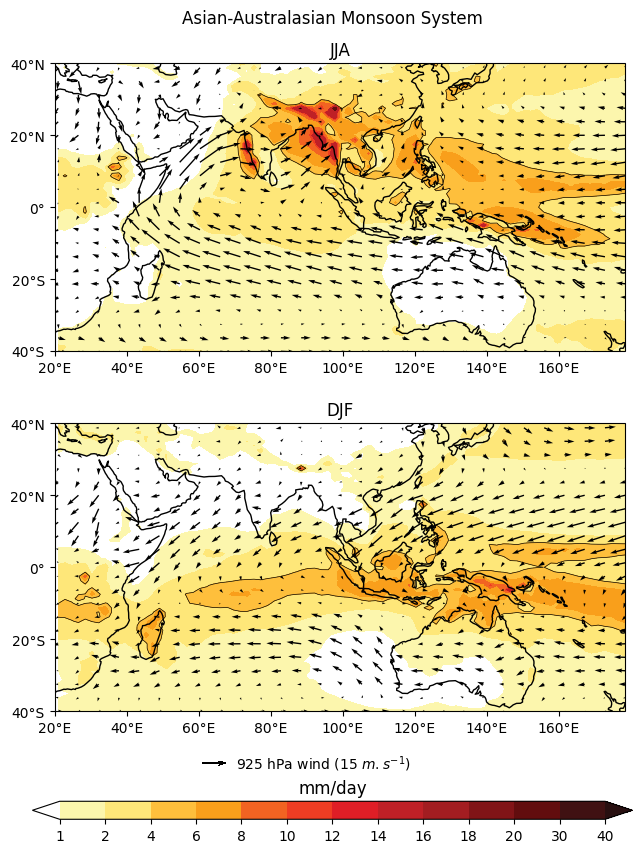

In [ ]:
# Data
P = dse_seas_clm.tp.sel(lat=slice(-40,40))# precipitation
U = dse3_seas_clm.u.sel(lat=slice(-40,40)).sel(level=925) # zonal wind
V = dse3_seas_clm.v.sel(lat=slice(-40,40)).sel(level=925) # latitude wind

# lats for P
lats = dse_seas_clm.lat.sel(lat=slice(-40,40))

# season for loop
vivaldi = ['JJA', 'DJF']

# levels for contourf and contour
tmp = np.append([1], np.arange(2,21, 2))
levels = np.append(tmp, [30, 40])

# cmap  (or hot_r)
myhot_cmap = mpl.colors.ListedColormap(['#fcf6ad', '#fee779', '#febf3c', '#f99f1b', '#f26322',
                                  '#ef3d23', '#df1e26', '#bf2026', '#a31d21', '#811417', '#620d0e', '#401112']).with_extremes(over='#280f10', under='#ffffff')

# projection
data_crs = ccrs.PlateCarree()

# Ticks
xticks=np.arange(20, 180, 20)
yticks=np.arange(-40, 41, 20)

# Figure
fig, axs = plt.subplots(nrows=2,ncols=1, subplot_kw={'projection': data_crs}, figsize=(15,9))

for i in range(2):

  ax = axs[i]

  # Rearange data
  Pright = P.sel(season=vivaldi[i]).sel(lon=slice(20,80))
  Pleft = P.sel(season=vivaldi[i]).sel(lon=slice(-280,-180))
  Pleft['lon'] = Pleft['lon'] +360
  Pboth = xr.concat([Pright, Pleft], dim = 'lon')

  Uright = U.sel(season=vivaldi[i]).sel(lon=slice(20,80))
  Uleft = U.sel(season=vivaldi[i]).sel(lon=slice(-280,-180))
  Uleft['lon'] = Uleft['lon'] +360
  Uboth = xr.concat([Uright, Uleft], dim = 'lon')

  Vright = V.sel(season=vivaldi[i]).sel(lon=slice(20,80))
  Vleft = V.sel(season=vivaldi[i]).sel(lon=slice(-280,-180))
  Vleft['lon'] = Vleft['lon'] +360
  Vboth = xr.concat([Vright, Vleft], dim = 'lon')

  # lons
  lons = Pboth.lon
  lons3 = Uboth.lon

  # coastlines
  ax.coastlines(resolution='auto', color='k')

  # Plot precipitation
  cs = ax.contourf(lons,lats,Pboth, transform = data_crs, cmap = myhot_cmap, levels = levels)
  ax.contour(lons,lats,Pboth, transform = data_crs, levels = [8], colors = 'k', linewidths = 0.5)  #8 mm contour

  # Plot wind vector field
  step = 3
  x = lons3[::step]
  y = Uboth.lat[::step]
  X,Y = np.meshgrid(x,y)
  U_quiv = Uboth[::step,::step]
  V_quiv = Vboth[::step,::step]

  Q = ax.quiver(X,Y,U_quiv, V_quiv, scale_units='xy', scale=2.3)

  # Ticks
  ax.set_xticks(xticks, crs=data_crs)
  ax.set_yticks(yticks, crs=data_crs)
  ax.xaxis.set_major_formatter(cticker.LongitudeFormatter())
  ax.yaxis.set_major_formatter(cticker.LatitudeFormatter())

  # Title
  ax.set_title(vivaldi[i])

# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(hspace = 0.25, bottom=0.2, top=0.92, left=0.07, right=0.94)

# Colorbar
bounds = levels
norm = mpl.colors.BoundaryNorm(bounds, myhot_cmap.N)
cbar_ax = fig.add_axes([0.3, 0.08, 0.4, 0.02])   # dimensions [left, bottom, width, height] in fraction of figure width and height of the new axes
cbar = fig.colorbar(mpl.cm.ScalarMappable(cmap=myhot_cmap, norm=norm), cax = cbar_ax, orientation='horizontal', extend = 'both', ticks=bounds)
cbar.ax.set_title('mm/day')

# Quiver key
ax.quiverkey(Q, X = 0.3, Y = -0.18, U = 15, label = r"925 hPa wind (15 $m.s^{-1}$)", labelpos='E')#,coordinates='figure')

# Title
fig.suptitle('Asian-Australasian Monsoon System')

*Briefly discuss the difference between the two seasons.*

The most significant differences are due to the monsoon, a seasonally reversing wind system with a distinctly wet summer and a dry winter.

During JJA, the SH southeasterly trade winds cross the equator over Somalia hence its name of "Somali Jet" and turn flowing northwest over south India, with a visible slowdown when the winds meet the Western Ghats mountain range along the westcoast of India. They then converge in the northwest part of the Bay of Bengal and along the Arakan mountains. These two slowdown zones are where the highest precipitation can be observed due to upslope flow along the mountains bordering each respective zone and correspond to the Indian monsoon. Australia and Southeast Africa are dry.

In DJF, the low tropospheric (925hPa) monsoon gyre has reversed, with winds flowing from northeast to southwest over Somalia and Ethiopia. This is consistant with the high precipitation over Africa around 15°S and Madagascar since high precipitation is correlated to high temperature and low pressure and so wind convergence zone. There is also high precipiation over Indonesia and North Australia corresponding to their summer monsoon. Somalia, India and Myanmar are dry.

## 6 Zonally averaged zonal mean monthly velocity in the stratosphere

In [ ]:
def altitude_from_pressure(P, P0=1013.25, T0=288.15, g=9.81, M=0.029, R=8.314):
    """
    Calculate altitude (h) as a function of pressure (P) using the barometric formula for stratosphere

    :param P: Pressure at altitude (in hecto pascals)
    :param P0: Standard pressure at sea level (in hecto pascals)
    :param T0: Standard temperature at sea level (in kelvin)
    :param g: Acceleration due to gravity (in meters per second squared)
    :param M: Molar mass of Earth's air (in kilograms per mole)
    :param R: Universal gas constant (in joules per mole per kelvin)
    :return: Altitude above sea level (in kilometers)
    """
    altitude = -(R*T0)/(g * M)*np.log(P/P0)/1000
    #altitude = -(R*T0)/g*np.log(P0/P)/1000
    return altitude

def pressure_from_altitude(h, P0=1013.25, T0=288.15, g=9.81, M=0.029, R=8.314):
    """
    Calculate pressure (P) as a function of altitude using the barometric formula for stratosphere

    :param h: altitude above sea level (in kilometers)
    :param P0: Standard pressure at sea level (in hecto pascals)
    :param T0: Standard temperature at sea level (in kelvin)
    :param g: Acceleration due to gravity (in meters per second squared)
    :param M: Molar mass of Earth's air (in kilograms per mole)
    :param R: Universal gas constant (in joules per mole per kelvin)
    :return: Pressure at altitude (in hecto pascals)
    """
    pressure = np.exp(-h*1000 /(R*T0)*(g * M)) * P0
    return pressure

Text(0.5, 0.98, 'Quasi-Biennial Oscillation (QBO) : Zonally averaged $\\overline{U}(z)$')

<ipython-input-17-f0b8901117d0>:13: RuntimeWarning: divide by zero encountered in log
  altitude = -(R*T0)/(g * M)*np.log(P/P0)/1000


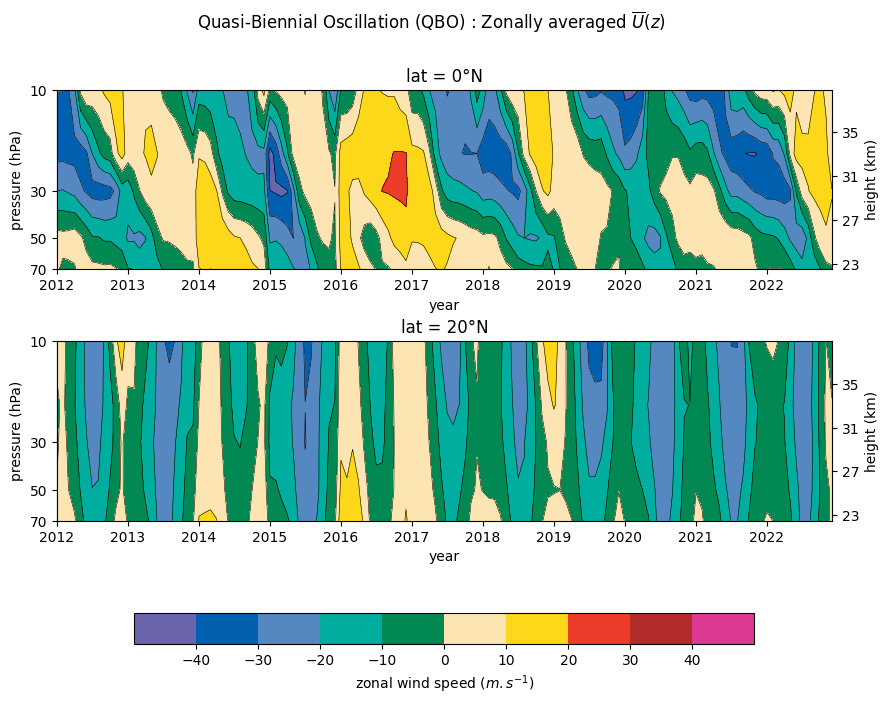

In [ ]:
# data
U_zavg = dse3.u.mean(dim='lon').sel(level=slice(10,70))

lats = [0, 20]
levels = np.arange(-50,51,10) # zonal wind speed levels

# pressure and altitude
pressure = dse3.level.sel(level=slice(10,70))
alt = altitude_from_pressure(dse3_seas_clm.level.sel(level=slice(10,70)))

# Ticks
ticks_p = [10, 30, 50, 70]
ticks_a = np.arange(np.ceil(alt.min()),np.ceil(alt.max()),4)

# Custom colormap
cmap_zws = mpl.colors.ListedColormap(['#6a64ac', '#0060af', '#5587c0', '#00ad9f', '#018853',
                                  '#fce5b2', '#fdd81a', '#ee3c2b', '#b22c2c', '#de3994'])

# figure
fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize=(10,8))

for i in range(2):
  ax = axs[i]

  # plot contours
  cs = ax.contourf(dse3.time,alt,U_zavg.sel(lat=lats[i]).transpose(), levels = levels, cmap = cmap_zws)
  ax.contour(dse3.time,alt,U_zavg.sel(lat=lats[i]).transpose(), levels = levels, colors ='k', linewidths = 0.4)

  ax.set_xlabel('year')

  ax.set_yticks(ticks_a)
  ax.set_ylabel('height (km)')
  ax.yaxis.set_label_position("right")
  ax.yaxis.tick_right()

  # Title
  ax.set_title('lat = ' + str(lats[i]) + '°N')

  ax2 = ax.secondary_yaxis('left', functions=(pressure_from_altitude, altitude_from_pressure))
  ax2.set_ylabel('pressure (hPa)')
  ax2.set_yticks(ticks_p)


# adjust spacing
fig.subplots_adjust(hspace = 0.4)

# Colorbar
cbar = fig.colorbar(cs, ax= axs.flatten(), orientation='horizontal', shrink=0.8, extend='both')
cbar.set_label('zonal wind speed ($m.s^{-1}$)')
cbar.set_ticks(np.arange(-40,41,10))

# Title
fig.suptitle('Quasi-Biennial Oscillation (QBO) : Zonally averaged $\overline{U}(z)$')

*How does the plot change for lat=20N? Discuss the main difference between the two plots*

<!-- The Positive denotes westerlies, negative easterlies -->

In the stratosphere above the equator we see a quasi-biennial oscillation (QBO) of the zonal wind direction whereas at 20°N we observe an annual oscillation in stratospheric winds' direction dominated by the easterly (negative values) tradewinds.

Another difference is that at the equator, there is a downward propagating phase with a rate of about 1km per month whereas at 20°N this is completely absent and at a given time most of the stratosphere column has the same wind velocity.

According to [\[1\]](#ref) the QBO is linked to vertically propagating tropospheric equatorial waves, and more precisely to the Madden-Julian Oscillation (MJO) with stronger activity in the easterly phase of the QBO than in its westerly phase. The MJO is observed in the tropical regions so rather over the equator than at 20°N.

\newpage

--------------------------------------
# Scherzo

<Figure size 640x480 with 0 Axes>

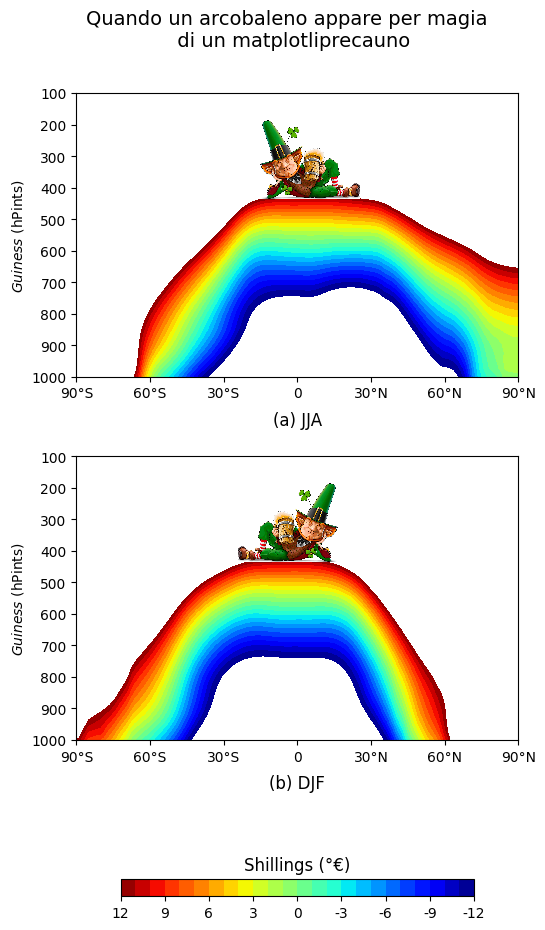

In [ ]:
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

plt.clf()

pathleps= drivedir+'/MyDrive/TASI_data_2023/lepsinistra.png'
pathlepd= drivedir+'/MyDrive/TASI_data_2023/lepdestra.png'
leps = [pathleps, pathlepd]
xs = [5.3,-4]

# Data : Shillings
T_zavg = dse3_seas_clm.t.mean(dim='lon').sel(level=slice(100,1000))

# Figure
fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(5.7,12))

level = np.arange(-12,13,1)

vivaldi = ['JJA','DJF']

# Ticks
major_xticks = np.arange(-90, 91, 30)
major_yticks = np.arange(100,1001,100)

for i in range(2):  #for ax in axs.flat:
  ax = axs[i]

  # plot
  cs = ax.contourf(dse3['lat'],dse3.level.sel(level=slice(100,1000)),T_zavg.sel(season=vivaldi[i]), levels = level, cmap ='jet_r')

  # invert and label yaxis
  ax.invert_yaxis()
  ax.set_ylabel('$Guiness$ (hPints)')

  # ticks
  ax.set_xticks(major_xticks)
  ax.set_yticks(major_yticks)
  ax.xaxis.set_major_formatter(plt.FuncFormatter(format_lat)) # format xaxis

  # leprechaun
  lep = mpimg.imread(leps[i])
  imagebox = OffsetImage(lep, zoom=0.03)
  ab = AnnotationBbox(imagebox, (0,500), xybox=(xs[i],312), frameon = False)
  ax.add_artist(ab)

# adjust spacing
fig.subplots_adjust(hspace = 0.28)

# color bar
cbar = fig.colorbar(cs, ax=axs[:], location='bottom', shrink=0.8, ticks=level[::3], extend='both')
cbar.ax.set_title('Shillings (°€)')
cbar.set_ticklabels(np.arange(12,-13,-3))

# title
axs[0].set_title('(a) JJA', y = -0.2)
axs[1].set_title('(b) DJF', y = -0.2)
fig.suptitle('Quando un arcobaleno appare per magia \n di un matplotliprecauno', fontsize =14, y=0.95)

#plt.show()
plt.savefig(drivedir+'/MyDrive/TASI_data_2023/arcobaleno.png', bbox_inches = 'tight')